In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install tensorflow --upgrade

In [ ]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/nns

embedding_matrix.npy  training.1600000.processed.noemoticon.csv
lstm		      training.200000.processed.noemoticon.csv
saved_tensors	      training.50000.processed.noemoticon.csv
saved_train_test      w2v_model.h5


In [ ]:
main_dir = '/content/drive/MyDrive/nns/'
dataset_path = main_dir+'training.1600000.processed.noemoticon.csv'
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/MyDrive/nns/training.1600000.processed.noemoticon.csv


Text(0.5, 1.0, 'Dataset labels distribuition')

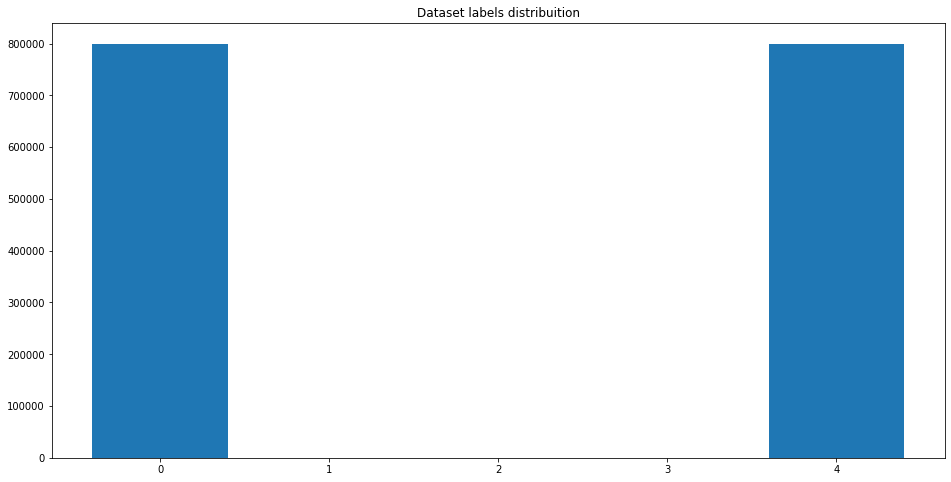

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
df.target = df.target.apply(lambda x: decode_sentiment(x))

In [ ]:
df = df.dropna()

In [ ]:
# randomly sample from each df
neg_df = df[df.target == 'NEGATIVE'].sample(n=25000, random_state=5)
pos_df = df[df.target == 'POSITIVE'].sample(n=25000, random_state=5)
df = pd.concat([neg_df, pos_df], axis=0)

In [ ]:
print("Number of 0s: ", len(df[df.target == 'NEGATIVE']))
print("Number of 4s: ", len(df[df.target == 'POSITIVE']))
print("Number of 2s: ", len(df[df.target == 'NEUTRAL']))


Number of 0s:  25000
Number of 4s:  25000
Number of 2s:  0


In [ ]:
df.to_csv('/content/drive/MyDrive/nns/training.50000.processed.noemoticon.csv')

Text(0.5, 1.0, 'Dataset labels distribuition')

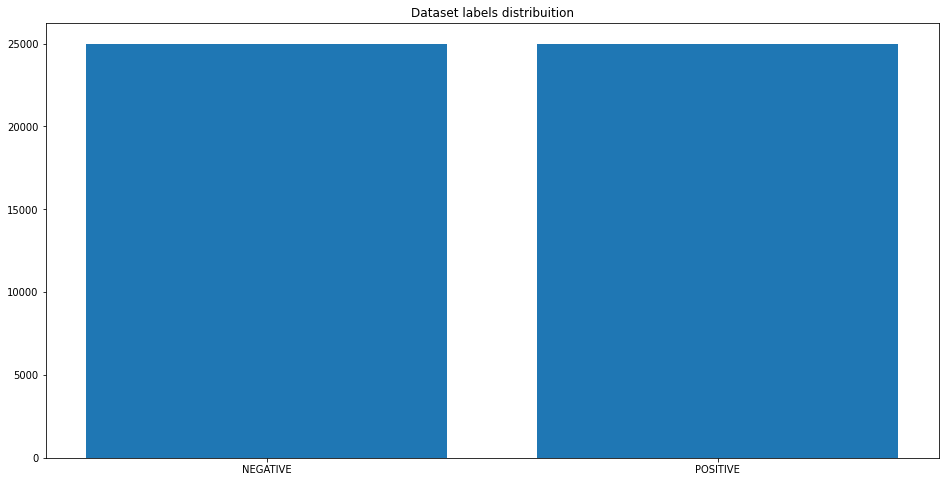

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 40000
TEST size: 10000


In [ ]:
df_train.head(3)

,target,ids,date,flag,user,text
1510294,POSITIVE,2174932017,Sun Jun 14 23:39:50 PDT 2009,NO_QUERY,themaninsd,man
1080976,POSITIVE,1968368807,Fri May 29 21:17:38 PDT 2009,NO_QUERY,bn1511,headin east boston
1014964,POSITIVE,1881502835,Fri May 22 04:50:19 PDT 2009,NO_QUERY,freakinkate,soon niagara lake trip class


In [ ]:
documents = [_text.split() for _text in df_train.text] 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 32965


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
labels = df_train.target.unique().tolist()
labels

['POSITIVE', 'NEGATIVE']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [ ]:
save_dir = '/content/drive/MyDrive/nns/saved_train_test/'
np.save(save_dir+'x_train', x_train)
np.save(save_dir+'y_train', y_train)
np.save(save_dir+'x_test', x_test)
np.save(save_dir+'y_test', y_test)